In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.ticker import AutoMinorLocator
import netCDF4 as nc4

ModuleNotFoundError: No module named 'numpy'

In [3]:
deg2m  = 1e5 # 1° to meters
deg2km = 1e2 # 1° to km
m2km   = 1e-3 # 1km to meters
km2m   = 1e3  # 1km to meters
km2deg = 1e-2
VA = 2.         # V-shape
UA = 1.         # U-shape

class Strait():
    # archive all the section of a given strait
    def __init__(self,name="nothing"):
        self.name = name        # name of the strait
        self.stra = []          # list of sections
        self.N    = 0           # nb of straits
        self.C    = 0.          # depth of the minimum shoulder
    
    def add(self,_strait):
        self.stra.append(_strait)
        self.N += 1 
    
class Section():
    # contains a collection of strait
    def __init__(self):
        self.A     = 0.    # surface section
        self.zb    = 0.    # deepest point 
        self.shape = UA    # V- or U-shape of the strait
        self.l     = 0.    # deduced width
        self.pos   = (0,0) # lon,lat
        self.t     = (0,0)
        self.n     = (0,0)
        self.C     = 0.   # depth of the shoulder


In [235]:
#pdt = "data_bathy/gebco/romanche/gebco_2022_n1.5_s-1.5_w-25.0_e-13.0.nc"   # ROMANCHE
pdt = "data_bathy/gebco/vema/gebco_2022_n-27.0_s-33.0_w-42.0_e-36.0.nc"   # VEMA
#pdt = "data_bathy/gebco/gibraltar/gebco_2022_n36.5_s35.5_w-6.5_e-5.0.nc"   # GIBRALTAR
#pdt = "data_bathy/gebco/lombok/gebco_2022_n-8.1052_s-9.0033_w115.2561_e116.406.nc"   # LOMBOK


dt = nc4.Dataset(pdt)
gdep = dt.variables['elevation'][:,:]
lon = dt.variables['lon'][:] ; lat = dt.variables['lat'][:]
dx = lon[1]-lon[0] ; dy = lat[1] - lat[0]
dt.close()
  
import numpy.ma as ma
gdep = np.ma.masked_where(gdep>=0,gdep)

#dz = (gdep.min()-np.quantile(gdep,0.75)) / 6
#dz = np.round(dz,-2) 
#blevels = np.arange(bvup,gdep.min()+dz,dz)[::-1]

# min -> Q2 -> Q5 -> Q8 - masked
bvup = np.round(np.quantile(gdep[~gdep.mask],0.8),-2) ; bvdo = np.round(gdep.min(),-2)
dz = np.round( (bvdo - bvup)/ 10., -2)
blevels = np.arange(bvup,bvdo,dz)[::-1]
if np.sum(blevels>=0) <=0:
    blevels = np.append(blevels,0.)

#blevels = [-8000, -7000, -6000, -5000, -4000, -3000, -2000, 0]


from matplotlib.colors import LinearSegmentedColormap 
cmap2 = LinearSegmentedColormap.from_list(name="custom_map", 
                                          colors =['DarkBlue', 
                                                   'CornflowerBlue', 
                                                   'white'],
                                          N=len(blevels))
cmap2.set_over('0.7')                                         # set positive values (land) as light gray

nX = np.shape(lon)[0] ; nY = np.shape(lat)[0]
glam =  np.repeat(lon[np.newaxis,:], nY, axis=0) ; gphi =  np.repeat(lat[:,np.newaxis], nX, axis=1)

In [236]:
print(np.quantile(gdep[~gdep.mask],0.8))
print(np.quantile(gdep[~gdep.mask],0.5))
print(np.quantile(gdep[~gdep.mask],0.2))
print(blevels)

-3273.0
-3942.0
-4404.0
[-4900. -4700. -4500. -4300. -4100. -3900. -3700. -3500. -3300.     0.]


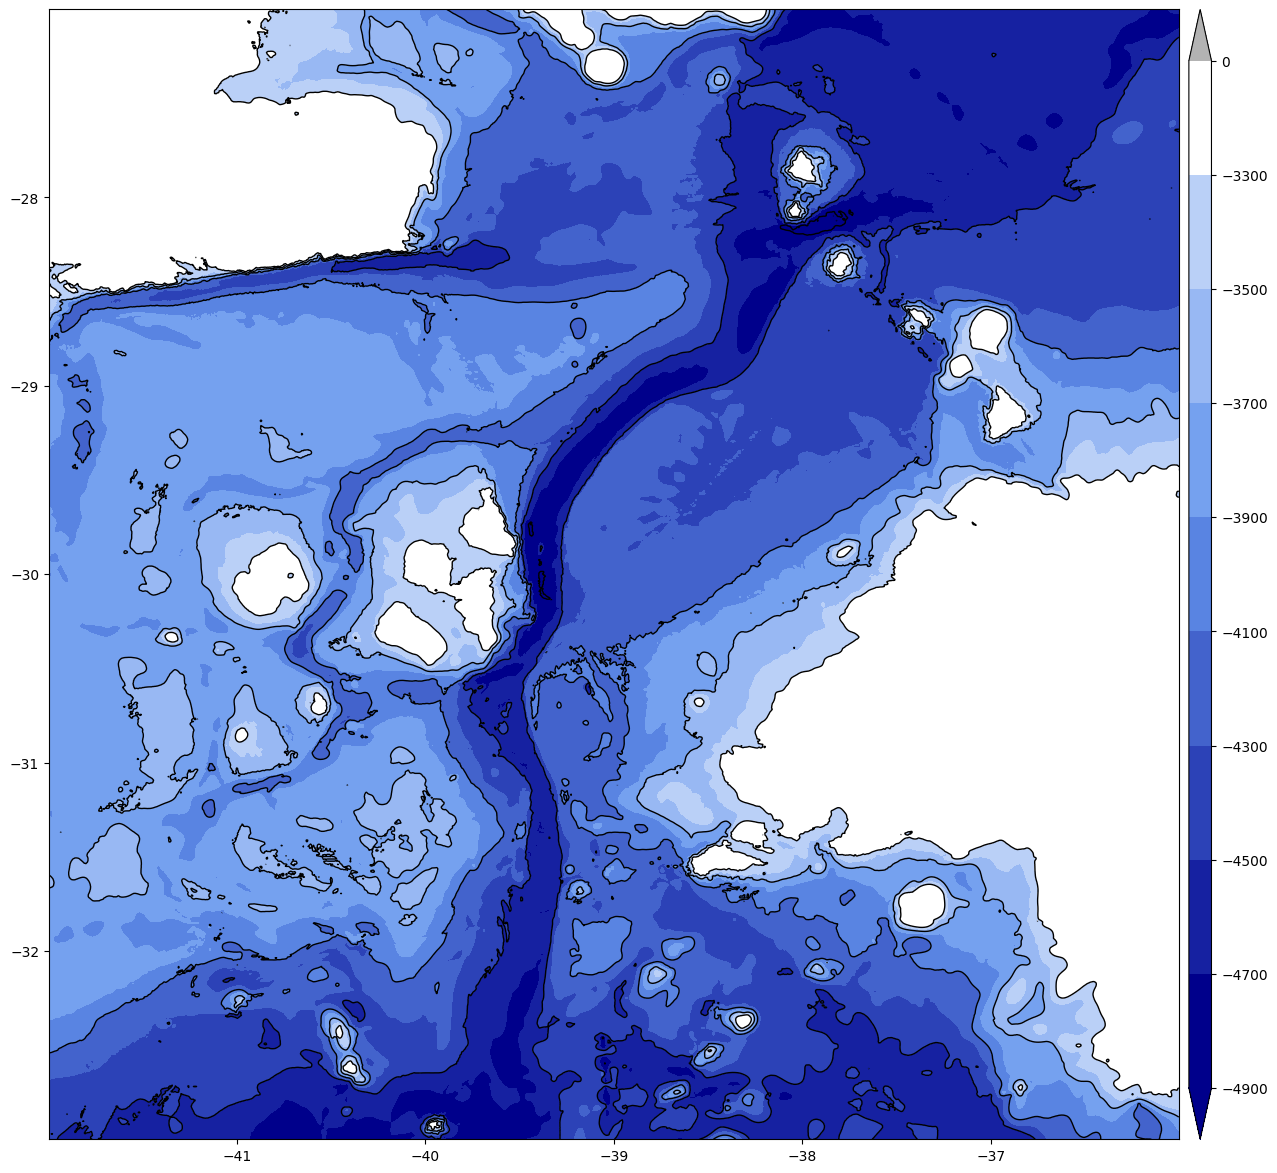

In [237]:
%matplotlib inline

from matplotlib.colors import BoundaryNorm
bnorm = BoundaryNorm(blevels, ncolors=len(blevels), clip=False)

fig, ax = plt.subplots(figsize=(15,15))
pc = ax.contourf(glam,gphi,gdep, corner_mask = False,
                    levels = blevels, extend='both', norm=bnorm,
                    cmap=cmap2)
ax.contour(glam,gphi,gdep, levels=blevels[::2], negative_linestyles = 'solid', colors='k', linewidths = 1.)
ax.set_aspect(aspect='equal')
ax.patch.set_color('0.7')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.1)
fig.colorbar(pc, ticks=blevels, spacing='uniform', cax=cax)
    
#ax.set_adjustable("box")
plt.show()

### Drawing the backbone of the strait
https://stackoverflow.com/questions/70947912/how-to-draw-lines-between-mouseclicks-on-a-matplotlib-plot

<IPython.core.display.Javascript object>


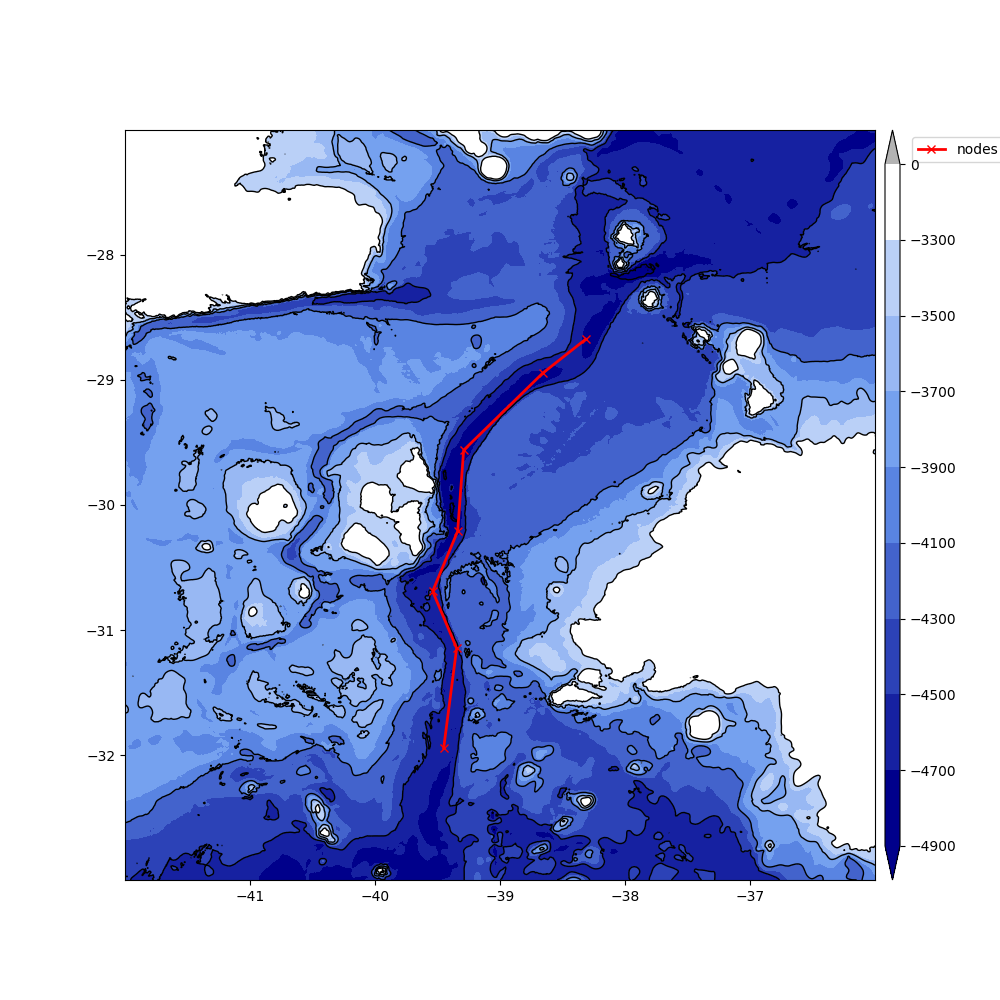

In [238]:
from mpl_point_clicker import clicker

%matplotlib notebook
fig, ax = plt.subplots(figsize=(10,10))

cf = plt.contourf(glam,gphi,gdep, 
                    levels = blevels, extend='both', norm=bnorm,
                    cmap=cmap2)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.1)
fig.colorbar(pc, ticks=blevels, spacing='uniform', cax=cax)
ax.contour(glam,gphi,gdep, levels=blevels[::2], negative_linestyles = 'solid', colors='k', linewidths = 1.)
ax.set_aspect(aspect='equal')
#cf = ax.pcolormesh(glam0,gphi0,gdep0,\
#               vmin=-8000, vmax=0, \
#               cmap=cmap2)
#fig.colorbar(cf,ticks=blevels, spacing='proportional')
#ax.contour(glam0,gphi0,gdep0, levels=blevels, negative_linestyles = 'solid', colors='k', linewidths = 1.)
#klicker = clicker(ax, ["event"], markers=["x"])
# https://mpl-point-clicker.readthedocs.io/en/latest/
klicker = clicker(ax, ["nodes"], markers=["x"], **{"linestyle": "-","colors":"red","linewidth":2})
ax.patch.set_color('0.7')


plt.show()

In [250]:
coor = klicker.get_positions()['nodes']
print(np.shape(coor))
Ni,_ = np.shape(coor)
print(coor)

(7, 2)
[[-39.45048675 -31.9445154 ]
 [-39.34655897 -31.14507096]
 [-39.53842564 -30.68938763]
 [-39.33856453 -30.20972096]
 [-39.29059786 -29.56217096]
 [-38.65903675 -28.94659874]
 [-38.31527564 -28.67478763]]


In [251]:
# Meaning to a lower resolution grid

n_grid = 8
nX0 = nX//n_grid ; nY0 = nY//n_grid
glam0 = np.zeros((nY0,nX0))
gphi0 = np.zeros((nY0,nX0))
gdep0 = np.zeros((nY0,nX0))

mask = np.zeros((nY,nX))
mask[gdep.mask==False] = 1.   # ocean
mask[gdep.mask==True ] = 0.
gdep_mask = ma.filled(gdep,0.)           
  
for i0 in range(nX0):
    for j0 in range(nY0):
        #
        tmp_w = 0. ; tmp_z = 0.
        for _i in range(n_grid):
            for _j in range(n_grid):
                #
                i = i0*n_grid + _i ; j = j0*n_grid + _j
                glam0[j0,i0] += glam[j,i]/(n_grid*n_grid)
                gphi0[j0,i0] += gphi[j,i]/(n_grid*n_grid)
                tmp_z        += gdep_mask[j,i]
                tmp_w        += mask[j,i]
        if tmp_w>0:
            gdep0[j0,i0] = tmp_z/tmp_w

gdep0 = np.ma.masked_where(gdep0>=0,gdep0)
print(np.shape(glam0))

(180, 180)


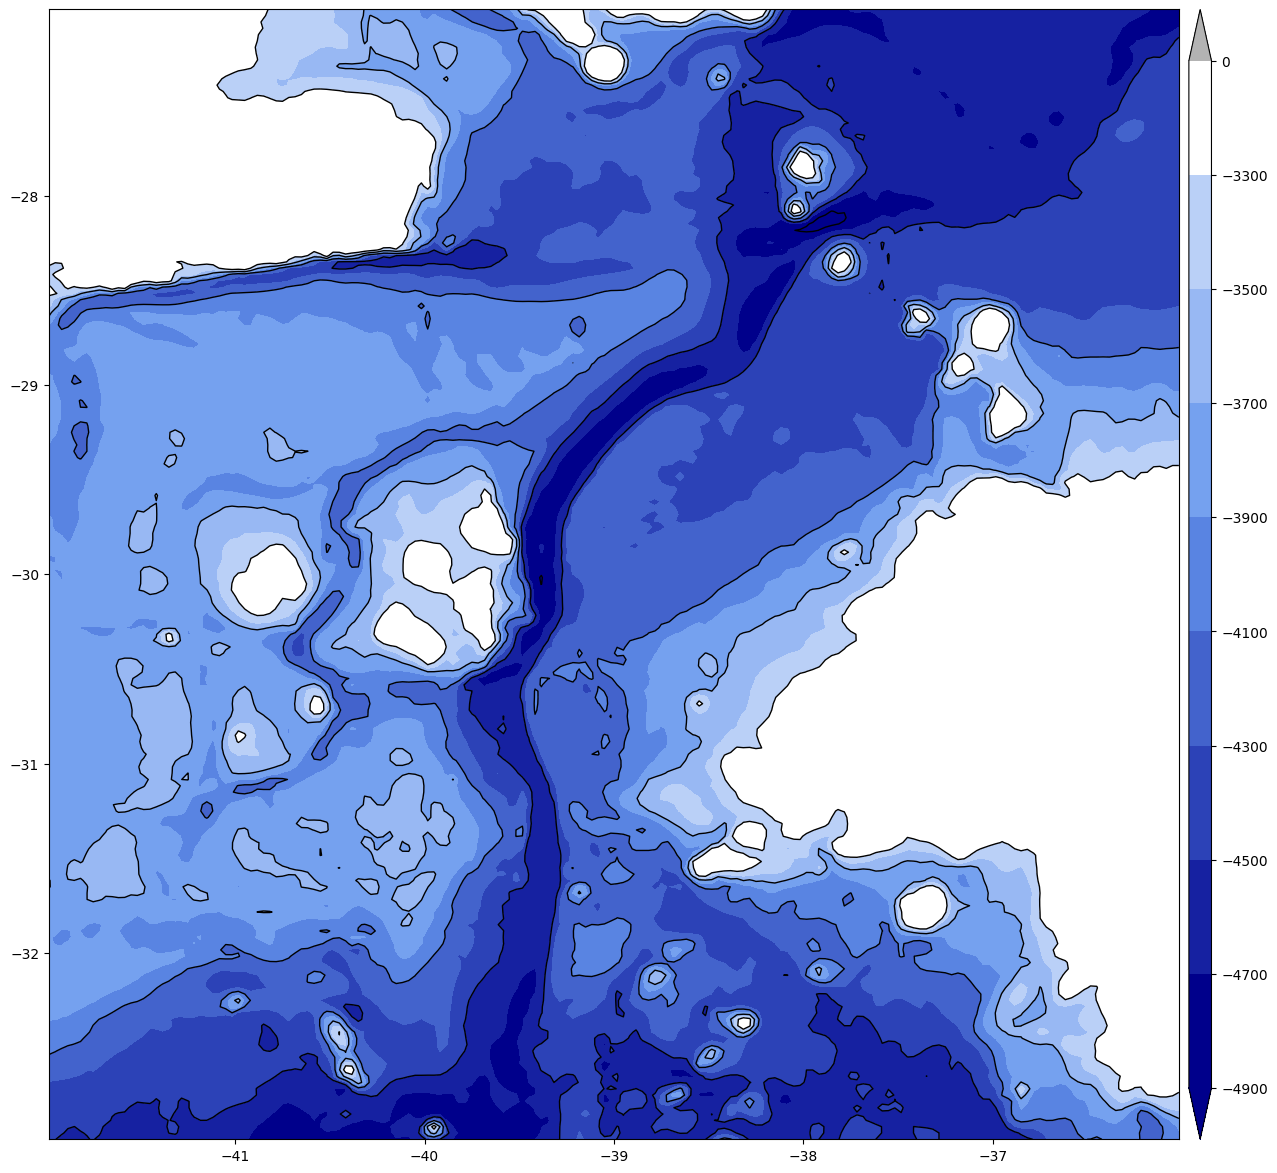

In [252]:
%matplotlib inline

fig, ax = plt.subplots(figsize=(15,15))
pc = ax.contourf(glam0,gphi0,gdep0, 
                    levels = blevels, extend='both', norm=bnorm,
                    cmap=cmap2)
ax.contour(glam0,gphi0,gdep0, levels=blevels[::2], negative_linestyles = 'solid', colors='k', linewidths = 1.)
ax.set_aspect(aspect='equal')
ax.patch.set_color('0.7')

from mpl_toolkits.axes_grid1 import make_axes_locatable
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.1)
fig.colorbar(pc, ticks=blevels, spacing='uniform', cax=cax)

#ax.set_adjustable("box")
plt.show()

### Ferron et al. 2000
Bernouilli potential $B_c(s,Q)$ depends on the position in the section $s$ and the upstream transport $Q$ :
$$
B_c(s,Q)= \dfrac{3}{2} \left(\dfrac{g'\,Q}{l(s)}\right)^{2/3} + g' b(s)
$$
with $g'= g \Delta \rho / \rho $ and $Q=A(s)\overline{u}(s)$. The inferred aspect of the strait is a U-shape that leads to define the control section $A(s) = l Z_b $ with $l$ the width and $Z_b$ the depth of the seafloor. If the shape was rather a V-shape, the surface would be $A=l Z_b / 2$ where $Z_b$ is the maximum depth and $l$ the base width. 

Here, we produce a set of widths and depths that describes the geometrical charasteristics of the strait. We manage to deduce the sections that are orthogonal to the spine of the strait. Then the surface section is estimated along with the bottom depth that allows us to approximate the width of the section by hypothesizing the U- or V-shape of the strait. The Bernoulli potential, or charge of the strait, is plotted along the strait which allows us ultimately to determine the control section and the orientation of the strait.

In [253]:
delta_rho = 0.1
rho = 45.89
g = 9.81
gp = g * delta_rho / rho
print("reduced gravity g=%.4f" % (gp))

# section coordinate
# between each position, interpol many nodes which serves as an along strait coordinate
ds = 0.1 # ° 
scoor = np.array(coor[0])
for i in range(Ni-1):
    A = np.array(coor[i]) ; B = np.array(coor[i+1])
    length = np.linalg.norm(B-A)
    dscos = ds*(B[0]-A[0])/length ; dssin = ds*(B[1]-A[1])/length
    ni = np.int64(length//ds)
    scoor = np.vstack( (scoor, [A[0], A[1]]) )
    for ii in range(1,ni):            #   x + dx           y + dy
        scoor = np.vstack( (scoor, [ A[0] + ii*dscos, A[1] + ii*dssin ]) )
scoor = np.delete( scoor, 0, axis = 0)
scoor = np.vstack( ( scoor, coor[-1] ) )
Ns = len(scoor)

reduced gravity g=0.0214


In [254]:
X = glam0.flatten()
Y = gphi0.flatten()
Z = gdep0.flatten()

smoothing = 3

save = 1

In [259]:
romanche = Strait()

#for i in range(Ns-1):
for i in [16]:
    current = Section()
    
    # deduces vectors and origin of the section (s_n,s_t,N)
    A = scoor[i] ; B = scoor[i+1]
    s_t = (B-A)/np.linalg.norm(B-A)
    s_n = np.array([-s_t[1],s_t[0]])
    N_continuous = (A+B)/2 # M = N + l*s_n
    
    # find closest N
    M = np.array( [X,Y] ).T                        # allongé sur nX
    tmp_N = np.argmin(np.linalg.norm(M-N_continuous,axis=1))
    #N_ji = ( tmp//nX0, tmp%nX0 ) # y,x
    #N_ij = ( tmp%nX0, tmp//nX0 ) # x,y
    N = np.array([X[tmp_N], Y[tmp_N]])   # discrete
    
   
    # find all nodes along the section (tmp_section_index)   
    NM = (M - N)                                                 
    NMcol = (NM[:,0]*s_t[0] + NM[:,1]*s_t[1])   # global
    
    """ --- Smoothing (piste d'amélioration) --- """
    #epsilon = n_grid*np.max((dx,dy))                          
    epsilon = 0.5 * n_grid*np.abs( dx*s_t[0] + dy*s_t[1] )  
    
    tmp_section_index = np.where( ( np.abs(NMcol)<epsilon) * 
                                  ( np.linalg.norm(M-N,axis=1) < 4.))[0]    # indices globaux (dans NMcol)
    if np.shape(Z.mask) != () :
        tmp_section_index = tmp_section_index[Z.mask[tmp_section_index]==False]
    
    # build normal profile of the section
    NMsec = (NM[tmp_section_index,0]*s_n[0] + NM[tmp_section_index,1]*s_n[1])    # local !
    tmp_sorted = np.argsort(NMsec)
    section_relpos       = NMsec[tmp_sorted]
    section_global_index = tmp_section_index[tmp_sorted]  # plotting Z[section_t] gives the depths along the section
                                                          # section_index global indexing, sorted
    
    # remove false (noisy) extrema by smoothing
    # too much smoothing can results in inverting the real maxima
    junk_z = np.copy(Z[section_global_index]) ; junk = np.copy(Z[section_global_index])
    for _ in range(smoothing):
        for ii in range(1,len(section_global_index)-1):
            junk[ii] = 0.25*junk_z[ii-1] + 0.5*junk_z[ii] + 0.25*junk_z[ii+1]
        junk_z = np.copy(junk)
        
    """ --- --- """
    
    # search for the crest and summit of the section
    section_local_index = np.arange(len(junk))     # local indexing
    #a = np.float64(np.diff(junk)>0)  
    a = np.float64(np.diff(np.append(np.append(-1E4,junk),-1E4))>0) 
    b = np.diff(a)                                 # local extrema
    n_min = np.where(b>0)[0]
    n_max = np.where(b<0)[0]
        
    """ ------------------------------------------------- """
    
    # local minimum close to the given center (in meters)
    section_local_N = np.argmin(np.abs(NMsec[tmp_sorted]))   # find closest N in the section indexing
    n0 = np.argmin( np.abs(n_min-section_local_N) )
    Zb_n = n_min[n0]
    Zb   = junk[Zb_n]
    
    ii = 0                        ### choose the two consecutive maxima to the minimum
    while ii < len(n_max)-1:      # n_max already sorted
        n1 = n_max[ii] ; n2 = n_max[ii+1]
        if Zb_n > n1 and Zb_n < n2 :
            break
        ii+=1
    if ii==len(n_max):
        print('Error: no maxima found')
    
    if junk[n1] < junk[n2]:       ### select the deepest maxima - the crest
        C=n1 ; S=n2
    else :
        S=n1 ; C=n2
    
    depthC = junk[C]
                                  ### deduce surface section for all the depths below the crest
    
    ### deduce surface section for all the depths below the crest
    local_index_strait = np.where( (junk <= depthC ) * \
                              (section_local_index <= n2)    * \
                              (section_local_index >= n1))[0]  
    
    """ --- Calcul de la largeur (piste d'amélioration) --- """
    weight = 0.*np.copy(local_index_strait)
    ni = len(local_index_strait)
    for ii in range(ni):
        if ii==ni-1 :
            weight[ii] = 0.5 * (section_relpos[local_index_strait[ii  ]] \
                             -  section_relpos[local_index_strait[ii-1]])
        elif ii==0 :
            weight[ii] = 0.5 * (section_relpos[local_index_strait[ii+1]] \
                             -  section_relpos[local_index_strait[ii  ]])
        else:
            weight[ii] = 0.5 * (section_relpos[local_index_strait[ii+1]] \
                             -  section_relpos[local_index_strait[ii-1]])
    

    section_surface = m2km*deg2km*np.sum(weight*(depthC - junk[local_index_strait]))   # in km square
    section_width   = current.shape*section_surface/((depthC - Zb)*m2km)               # in kilometers
    
    height = Zb    # référence à 0m
    # height = depthC - Zb   # il faut un geopotentiel
    
    if (section_width<0.): 
        print("error section %d" % (i))
        break
        
    """ *** """
    
    #section_width = intersection
    #section_surface = current.shape * section_width * m2km *(romanche.C - Zb)   # in km2
    
    """ --- --- """
    # Save 
    if save == 1 :
        current.A  = section_surface
        current.zb = height                                           # m
        current.l  = section_width                                # km
        current.pos = np.array((X[section_global_index[Zb_n]], \
                                Y[section_global_index[Zb_n]]))   # deg
        current.t   = s_t
        current.n   = s_n
        current.C   = junk[C]
        
        romanche.add(current)


In [256]:
# Ferron et al. (2000) data
ferron = 0

if ferron:
    import csv
    from scipy import interpolate
    ferron = "data_bathy/Ferron_etal_2000/"

    xx = [] ; ww = []
    with open(ferron+'width.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        line_count = 0
        for row in csv_reader:
            xx.append(np.float64(row[0].replace(',', '.')))
            ww.append(np.float64(row[1].replace(',', '.')))
            line_count += 1
        print(f'Processed {line_count} lines.')
    ww = np.array(ww) ; xx = np.array(xx)

    wwf = interpolate.interp1d(xx,ww, fill_value = 'extrapolate')

    xx = [] ; hh = []
    with open(ferron+'height.csv') as csv_file:
        csv_reader = csv.reader(csv_file, delimiter=';')
        line_count = 0
        for row in csv_reader:
            xx.append(np.float64(row[0].replace(',', '.'))) 
            hh.append(np.float64(row[1].replace(',', '.')))
            line_count += 1
        print(f'Processed {line_count} lines.')
    hh = np.array(hh) ; xx = np.array(xx)

    hhf = interpolate.interp1d(xx,hh, fill_value = 'extrapolate')

""" ------------------------------------------ """    

    list_pos_interp = np.arange(0,500,1)

    kwargs = {"linewidth" : 1, "marker" : "o","markersize" : 2}
    %matplotlib inline
    fig = plt.figure(figsize = (10,8))

    ax = fig.add_subplot(211)
    ax2 = ax.twinx()

    ax.plot(list_pos_interp,wwf(list_pos_interp), 
            label = '_no_legend_',  linestyle = '-', color = "grey", zorder = 2,**kwargs)
    ax2.plot(list_pos_interp,hhf(list_pos_interp) -  np.min(hhf(list_pos_interp)), 
         label = '_no_legend_', linestyle = '-',  zorder = 3, color ="black", **kwargs)

    lns = ln1+ln2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc =2)

    ax.grid(axis = 'x', which = "both")
    ax.set_xlim(list_pos_interp[0],list_pos_interp[-1])
    ax.set_ylabel(r"width (km)")
    ax2.set_ylabel(r"height (m)")

    ax.yaxis.set_minor_locator(AutoMinorLocator())
    ax2.yaxis.set_minor_locator(AutoMinorLocator())

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'x',which = 'both', bottom = True, top = True)

    """ -------------------------------- """
    ax = fig.add_subplot(212) 

    def bernouilli(w,z,q):
        a = gp * q / w
        result = (3./2.) * np.power(a,2/3) + gp * z
        return(result)

    Q = np.array([0.2,0.7,1.2,1.7,2.2,2.7,3.2]) * 1e6 # Sv
    nq = len(Q)


    for qi in range(nq):
        ax.plot(list_pos_interp,bernouilli(wwf(list_pos_interp)*km2m,                       \
                                    hhf(list_pos_interp) -  np.min(hhf(list_pos_interp)),   \
                                     Q[qi]),                             \
                zorder = (nq - qi)+1, linestyle = '--',                  \
                label = '_no_legend_' % (Q[qi]/1e6), color = str(qi/nq),       \
                **kwargs)

    ax.legend()
    ax.set_xlabel("x(km)")
    ax.set_xlim(list_pos_interp[0],list_pos_interp[-1])
    ax.set_ylabel(r"Potential Charge (J/kg)")

    ax.grid(axis = 'x', which = "both")
    ax.yaxis.set_minor_locator(AutoMinorLocator())

    ax.xaxis.set_minor_locator(AutoMinorLocator())
    ax.tick_params(axis = 'x',which = 'both', bottom = True, top = True)
    ax.tick_params(axis = 'y',which = 'both', left = True, right = True)
    plt.show()

IndentationError: unexpected indent (3946039326.py, line 37)

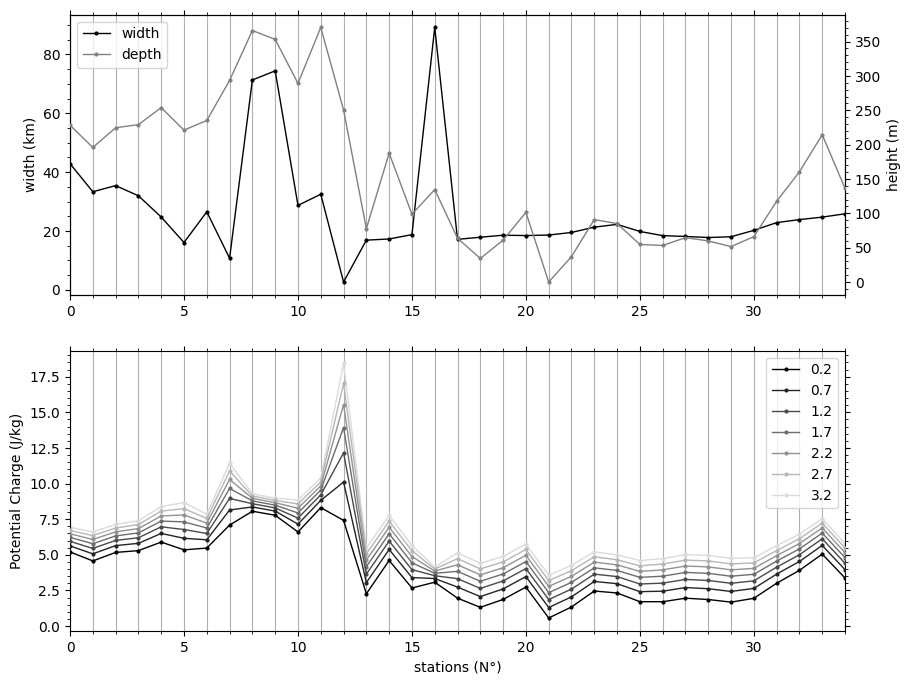

In [257]:
list_bot = []
list_pos = [] ; Nim1 = romanche.stra[0].pos 
list_wid = []
list_A   = []
for strait in romanche.stra :
    list_bot.append(strait.zb)
    list_wid.append(strait.l)
    list_A.append(strait.A)
    
    Nim = strait.pos
    s = deg2km*np.linalg.norm(Nim-Nim1)
    list_pos.append(s)

list_sta = np.arange(romanche.N)
list_wid = np.array(list_wid)
list_bot = np.array(list_bot)

list_pos_interp = list_pos/list_pos[-1]*500.

kwargs = {"linewidth" : 1, "marker" : "o","markersize" : 2}
%matplotlib inline
fig = plt.figure(figsize = (10,8))

ax = fig.add_subplot(211)
ln1 = ax.plot(list_sta,list_wid, label = 'width', color = "black", zorder = 2, **kwargs)
ax2 = ax.twinx()
ln2 = ax2.plot(list_sta,list_bot -  np.min(list_bot), label = 'depth', zorder = 3, color ="grey", **kwargs)

if ferron:
    ax.plot(list_pos,wwf(list_pos_interp), 
            label = '_no_legend_',  linestyle = '--', color = "red", zorder = 2, linewidth = 1.)
    ax2.plot(list_pos,hhf(list_pos_interp) -  np.min(hhf(list_pos_interp)), 
         label = '_no_legend_', linestyle = '--',  zorder = 3, color ="orange", linewidth = 1.)

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc =2)

ax.grid(axis = 'x', which = "both")
ax.set_xlim(list_sta[0],list_sta[-1])
ax.set_ylabel(r"width (km)")
ax2.set_ylabel(r"height (m)")

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'x',which = 'both', bottom = True, top = True)

""" -------------------------------- """
ax = fig.add_subplot(212) 

def bernouilli(w,z,q):
    a = gp * q / w
    result = (3./2.) * np.power(a,2/3) + gp * z
    return(result)

Q = np.array([0.2,0.7,1.2,1.7,2.2,2.7,3.2]) * 1e6 # Sv
nq = len(Q)

for qi in range(nq):
    ax.plot(list_sta,bernouilli(list_wid*km2m,                       \
                                (list_bot - np.min(list_bot)),   \
                                 Q[qi]),                             \
            zorder = (nq - qi)+1,                                      \
            label = '%1.1f' % (Q[qi]/1e6), color = str(qi/nq),       \
            **kwargs)
if ferron:
    for qi in range(nq):
        ax.plot(list_pos,bernouilli(wwf(list_pos_interp)*km2m,                       \
                                    hhf(list_pos_interp) -  np.min(hhf(list_pos_interp)),   \
                                     Q[qi]),                             \
                zorder = (nq - qi)+1, linestyle = '--',                  \
                label = '_no_legend_' % (Q[qi]/1e6), color = str(qi/nq),       \
                **kwargs)

ax.legend()
ax.set_xlabel("stations (N°)")
ax.set_xlim(list_sta[0],list_sta[-1])
ax.set_ylabel(r"Potential Charge (J/kg)")

ax.grid(axis = 'x', which = "both")
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'x',which = 'both', bottom = True, top = True)
ax.tick_params(axis = 'y',which = 'both', left = True, right = True)
plt.show()

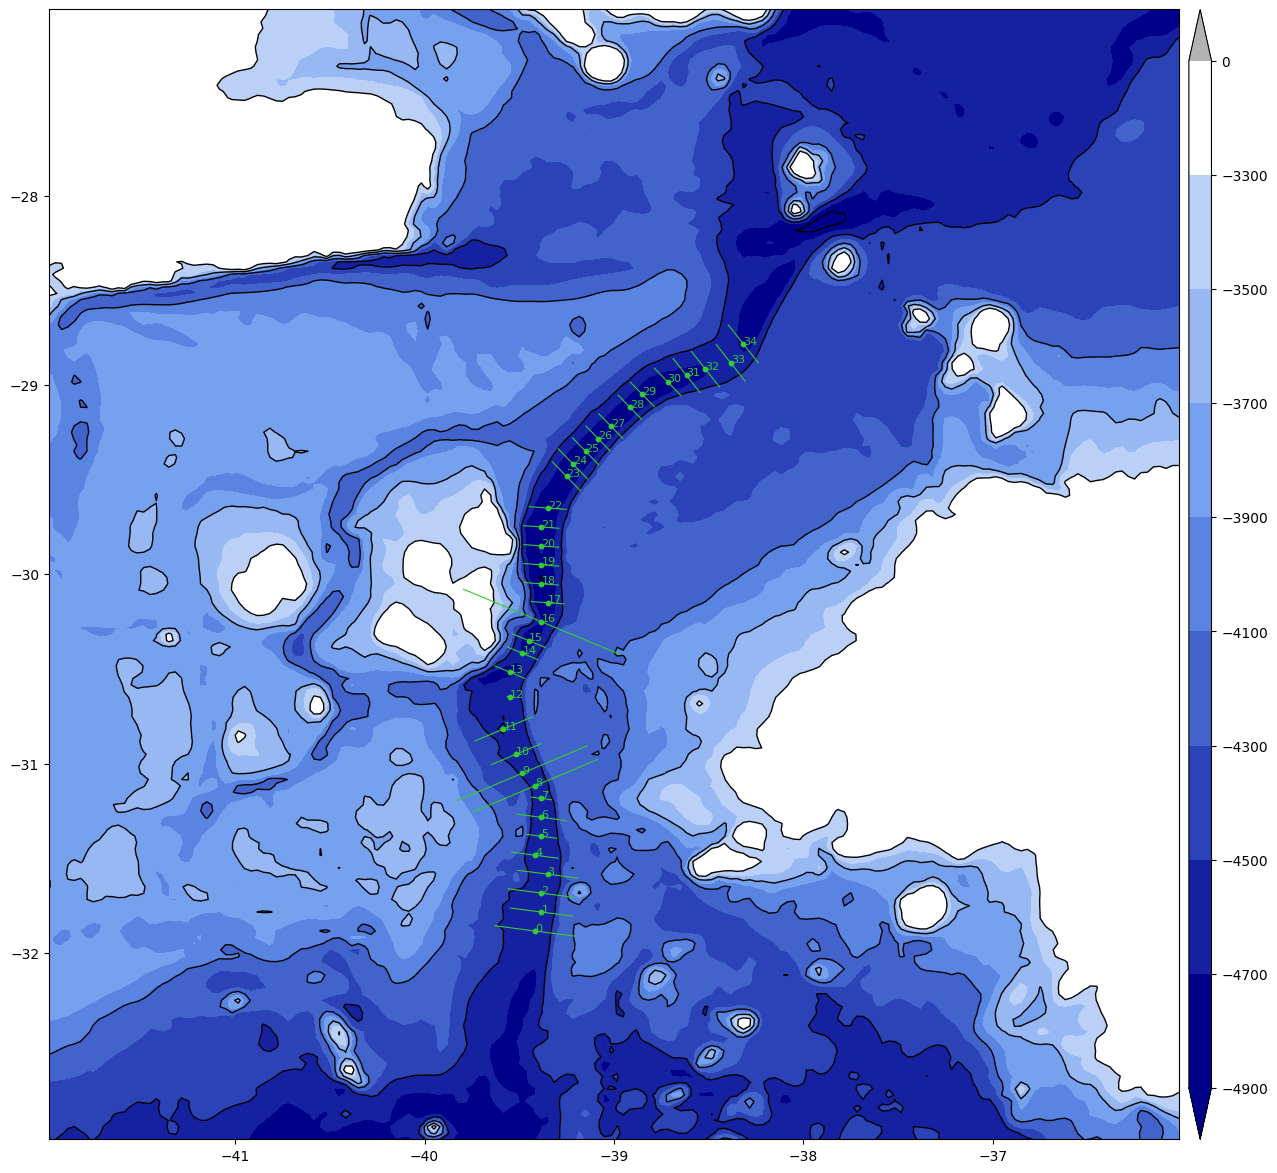

In [258]:
%matplotlib inline
fig, ax = plt.subplots(figsize = (15,15))
cf = plt.contourf(glam0,gphi0,gdep0, 
                    levels = blevels, extend='both', norm=bnorm,
                    cmap=cmap2)

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.1)
fig.colorbar(cf, ticks=blevels, spacing='uniform', cax=cax)

ax.contour(glam0,gphi0,gdep0, levels=blevels[::2], negative_linestyles = 'solid', colors='k', linewidths = 1.)
#ax.set_xlim(-23,-14)
#ax.set_ylim(-1.5,1.)
ax.set_aspect(aspect='equal')
ax.patch.set_color('0.7')

#for i in range(Ni):
#    ax.scatter( coor[i][0], coor[i][1],s=30, c = 'red')
#for i in range(Ns):
#    ax.scatter(scoor[i,0], scoor[i,1], s=20, c = 'red')
#    ax.scatter(scoor[i][0],scoor[i][1],s=10, c = 'white')

    
for i in range(romanche.N) :
    strait = romanche.stra[i]
    A = strait.pos - 0.5 * km2deg * strait.l * strait.n
    B = strait.pos + 0.5 * km2deg * strait.l * strait.n
    ax.plot([A[0],B[0]] , \
            [A[1],B[1]] , color = "limegreen", lw = 0.8)
    ax.scatter(strait.pos[0], strait.pos[1], s=10,  c = 'limegreen', zorder = 2)
    ax.annotate(i, strait.pos, color = "limegreen", fontsize = 8)

plt.show()

---

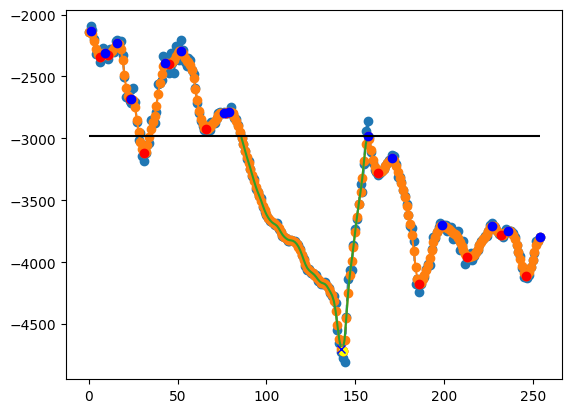

In [260]:

# create section coordinates
section_smoZ = junk[local_index_strait]
section_dept =    Z[section_global_index[local_index_strait]]
section_glam =    X[section_global_index[local_index_strait]]
section_gphi =    Y[section_global_index[local_index_strait]]


%matplotlib inline
plt.figure()
plt.plot(section_local_index, Z[section_global_index],'o--')
plt.plot(section_local_index, junk,'o-')
plt.plot(local_index_strait, junk[local_index_strait])
plt.plot(section_local_index[n_min], junk[n_min],'o',c="red"   )
plt.plot(section_local_index[Zb_n ], junk[Zb_n ],'o',c="yellow")
plt.plot(section_local_index[n_max], junk[n_max],'o',c="blue"  )
plt.plot(section_local_index[section_local_N], junk[section_local_N],'x',c="blue")
plt.hlines(y=junk[C], xmin=section_local_index[0], xmax=section_local_index[-1],color='k')
plt.show()

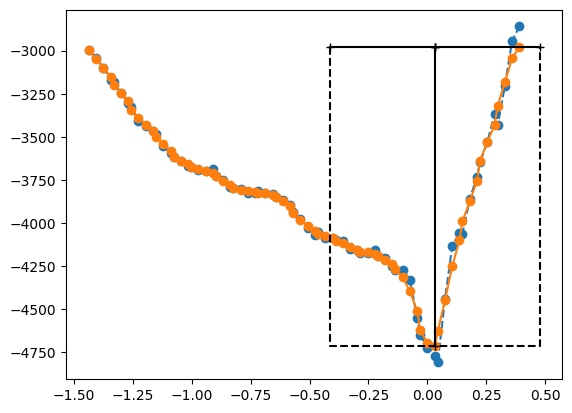

In [261]:

%matplotlib inline
plt.figure()
plt.plot(section_relpos[local_index_strait]  , section_dept,'o--')
plt.plot(section_relpos[local_index_strait]  , section_smoZ,'o-')

plt.plot([section_relpos[Zb_n]-km2deg*section_width/2.,section_relpos[Zb_n] ], \
         [junk[C], junk[C]],color='k',marker="+")
plt.plot([section_relpos[Zb_n]                        ,section_relpos[Zb_n]+km2deg*section_width/2. ], \
         [junk[C], junk[C]],color='k',marker="+")
plt.plot([section_relpos[Zb_n],section_relpos[Zb_n]], \
         [junk[C], Zb],     color='k',marker="+")

if current.shape == VA :
    plt.plot([section_relpos[Zb_n]-km2deg*section_width/2.,section_relpos[Zb_n],section_relpos[Zb_n]+km2deg*section_width/2. ], \
             [junk[C], Zb,junk[C]],'k--')
elif current.shape == UA :
    plt.plot([section_relpos[Zb_n]-km2deg*section_width/2., \
              section_relpos[Zb_n]-km2deg*section_width/2., \
              section_relpos[Zb_n]+km2deg*section_width/2., \
              section_relpos[Zb_n]+km2deg*section_width/2. ], \
             [junk[C], Zb,Zb, junk[C]],'k--')
plt.show()

<IPython.core.display.Javascript object>


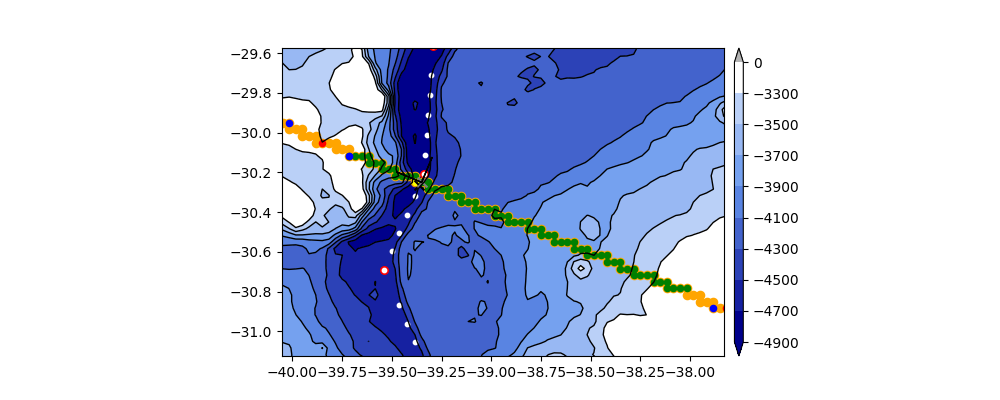

In [262]:
%matplotlib notebook
fig, ax = plt.subplots(figsize = (10,4))
cf = plt.contourf(glam0,gphi0,gdep0, 
                    levels = blevels, extend='both', norm=bnorm,
                    cmap=cmap2)
ax.contour(glam0,gphi0,gdep0, levels=blevels, 
           negative_linestyles = 'solid', colors='k', linewidths = 1.)
ax.set_aspect(aspect='equal') # data coordinate 'equal'
ax.patch.set_color('0.7')
#ax.grid(True, which='minor', axis='both', linestyle='-', color='w')
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='2%', pad=0.1)
fig.colorbar(cf, ticks=blevels, spacing='uniform', cax=cax)
for node in coor:
    ax.scatter(node[0],node[1],s=30, c = 'red')
for node in scoor:
    ax.scatter(node[0],node[1],s=10, c = 'white')


for i in section_global_index:
    ax.scatter(X[i],Y[i],s=35, c = 'orange')
for i in range(len(section_glam)):
    ax.scatter(section_glam[i],section_gphi[i],s=20, c = 'green')

for i in n_max:
    ax.scatter(X[section_global_index[section_local_index[i]]],
               Y[section_global_index[section_local_index[i]]],s=20, c = 'blue')
for i in n_min:
    ax.scatter(X[section_global_index[section_local_index[i]]],
               Y[section_global_index[section_local_index[i]]],s=20, c = 'red')
ax.scatter(X[section_global_index[section_local_index[Zb_n]]],
           Y[section_global_index[section_local_index[Zb_n]]],s=20, c = 'yellow')

#plt.plot(section_local_index[n_min], junk[n_min],'o',c="red"   )
#plt.plot(section_local_index[Zb_n ], junk[Zb_n ],'o',c="yellow")
#plt.plot(section_local_index[n_max], junk[n_max],'o',c="blue"  )
#plt.plot(section_local_index[section_local_N], junk[section_local_N],'x',c="blue")

ax.scatter(X[section_global_index[section_local_index[section_local_N]]],
           Y[section_global_index[section_local_index[section_local_N]]],s=50, c = 'green',marker='x')
ax.scatter(N_continuous[0],N_continuous[1],s=50, c = 'black',marker='x')
ax.scatter(N[0],N[1],s=50, c = 'grey',marker='x')
ax.arrow (N[0],N[1],4*n_grid*dx*s_t[0],
                    4*n_grid*dy*s_t[1], zorder =1)
ax.arrow (N[0],N[1],4*n_grid*dx*s_n[0],
                    4*n_grid*dy*s_n[1], zorder =1)

#ax.scatter(glam0[N_ji],gphi0[N_ji], s=50, c='k', zorder = 2)
plt.show()

----
## Shoulder (not used)

In [ ]:
save = 1
romanche = Strait()

for i in range(Ns-1):
#for i in [15]:
    
    # deduces vectors and origin of the section (s_n,s_t,N)
    A = scoor[i] ; B = scoor[i+1]
    s_t = (B-A)/np.linalg.norm(B-A)
    s_n = np.array([-s_t[1],s_t[0]])
    N_continuous = (A+B)/2 # M = N + l*s_n
    
    # find closest N
    M = np.array( [X,Y] ).T                        # allongé sur nX
    tmp_N = np.argmin(np.linalg.norm(M-N_continuous,axis=1))
    #N_ji = ( tmp//nX0, tmp%nX0 ) # y,x
    #N_ij = ( tmp%nX0, tmp//nX0 ) # x,y
    N = np.array([X[tmp_N], Y[tmp_N]])
    
    # find all nodes along the section (tmp_section_index)
    NM = (M - N)
    NMcol = (NM[:,0]*s_t[0] + NM[:,1]*s_t[1])
    #epsilon = n_grid*np.max((dx,dy))                          
    epsilon = 0.5 * n_grid*( dx*s_t[0] + dy*s_t[1] )                          
    tmp_section_index = np.where( ( np.abs(NMcol)<epsilon) * \
                                  ( np.linalg.norm(M-N,axis=1) < 0.6))[0]
    
    # build normal profile of the section
    NMsec = (NM[tmp_section_index,0]*s_n[0] + NM[tmp_section_index,1]*s_n[1])
    tmp_sorted = np.argsort(NMsec)
    section_relpos       = NMsec[tmp_sorted]              # local cooordinate (colinear length)
    section_global_index = tmp_section_index[tmp_sorted]  # plotting Z[section_t] gives the depths along the section
                                                          # global indexing
    
    # remove false (noisy) extrema by smoothing
    # too much smoothing can results in inverting the real maxima
    junk_z = np.copy(Z[section_global_index]) ; junk = np.copy(Z[section_global_index])
    for _ in range(smoothing):
        for ii in range(1,len(section_global_index)-1):
            junk[ii] = 0.25*junk_z[ii-1] + 0.5*junk_z[ii] + 0.25*junk_z[ii+1]
        junk_z = np.copy(junk)
    
    # search for the crest and summit of the section
    section_local_index = np.arange(len(junk))     # local indexing
    #a = np.float64(np.diff(junk)>0)  
    a = np.float64(np.diff(np.append(np.append(-1E4,junk),-1E4))>0) 
    b = np.diff(a)                                 # local extrema
    n_min = np.where(b>0)[0]
    n_max = np.where(b<0)[0]
            
    ii = 0                        ### choose the two consecutive maxima to the minimum
    while ii < len(n_max)-1:      # n_max already sorted
        n1 = n_max[ii] ; n2 = n_max[ii+1]
        if Zb_n > n1 and Zb_n < n2 :
            break
        ii+=1
    if ii==len(n_max):
        print('Error: no maxima found')
        
    if junk[n1] < junk[n2]:       ### select the deepest maxima - the crest
        C=n1 ; S=n2
    else :
        S=n1 ; C=n2
                                  ### deduce surface section for all the depths below the crest
    
    # Save 
    if save == 1 :        
        romanche.C = np.min([junk[C],romanche.C])

print(romanche.C)

## Ferron et al. (2000)

In [ ]:
list_bot = []
list_pos = [] ; Nim1 = romanche.stra[0].pos 
list_wid = []
list_A   = []
for strait in romanche.stra :
    list_bot.append(strait.zb)
    list_wid.append(strait.l)
    list_A.append(strait.A)
    
    Nim = strait.pos
    s = deg2km*np.linalg.norm(Nim-Nim1)
    list_pos.append(s)

list_sta = np.arange(romanche.N)
list_wid = np.array(list_wid)
list_bot = np.array(list_bot)

list_pos_interp = list_pos/list_pos[-1]*500.

kwargs = {"linewidth" : 1, "marker" : "o","markersize" : 2}
%matplotlib inline
fig = plt.figure(figsize = (10,8))

ax = fig.add_subplot(211)
ln1 = ax.plot(list_sta,list_wid, label = 'width', color = "black", zorder = 2, **kwargs)
ax2 = ax.twinx()
ln2 = ax2.plot(list_sta,list_bot -  np.min(list_bot), label = 'depth', zorder = 3, color ="grey", **kwargs)

if ferron:
    ax.plot(list_pos,wwf(list_pos_interp), 
            label = '_no_legend_',  linestyle = '--', color = "red", zorder = 2, linewidth = 1.)
    ax2.plot(list_pos,hhf(list_pos_interp) -  np.min(hhf(list_pos_interp)), 
         label = '_no_legend_', linestyle = '--',  zorder = 3, color ="orange", linewidth = 1.)

lns = ln1+ln2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc =2)

ax.grid(axis = 'x', which = "both")
ax.set_xlim(list_sta[0],list_sta[-1])
ax.set_ylabel(r"width (km)")
ax2.set_ylabel(r"height (m)")

ax.yaxis.set_minor_locator(AutoMinorLocator())
ax2.yaxis.set_minor_locator(AutoMinorLocator())

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'x',which = 'both', bottom = True, top = True)

""" -------------------------------- """
ax = fig.add_subplot(212) 

def bernouilli(w,z,q):
    a = gp * q / w
    result = (3./2.) * np.power(a,2/3) + gp * z
    return(result)

Q = np.array([0.2,0.7,1.2,1.7,2.2,2.7,3.2]) * 1e6 # Sv
nq = len(Q)

for qi in range(nq):
    ax.plot(list_sta,bernouilli(list_wid*km2m,                       \
                                (list_bot - np.min(list_bot)),   \
                                 Q[qi]),                             \
            zorder = (nq - qi)+1,                                      \
            label = '%1.1f' % (Q[qi]/1e6), color = str(qi/nq),       \
            **kwargs)
if ferron:
    for qi in range(nq):
        ax.plot(list_pos,bernouilli(wwf(list_pos_interp)*km2m,                       \
                                    hhf(list_pos_interp) -  np.min(hhf(list_pos_interp)),   \
                                     Q[qi]),                             \
                zorder = (nq - qi)+1, linestyle = '--',                  \
                label = '_no_legend_' % (Q[qi]/1e6), color = str(qi/nq),       \
                **kwargs)

ax.legend()
ax.set_xlabel("stations (N°)")
ax.set_xlim(list_sta[0],list_sta[-1])
ax.set_ylabel(r"Potential Charge (J/kg)")

ax.grid(axis = 'x', which = "both")
ax.yaxis.set_minor_locator(AutoMinorLocator())

ax.xaxis.set_minor_locator(AutoMinorLocator())
ax.tick_params(axis = 'x',which = 'both', bottom = True, top = True)
ax.tick_params(axis = 'y',which = 'both', left = True, right = True)
plt.show()